## Diabetes research

### imports modules and data

In [575]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import HBox, Label

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import joblib

In [423]:
diabetes_df = pd.read_csv('diabetes.csv')

In [424]:
diabetes_df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### preliminary analysis

In [425]:
diabetes_df.describe(include="all")

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [426]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [427]:
numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age','Outcome']


In [428]:
plots_palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
plots_color = '#6380a8'

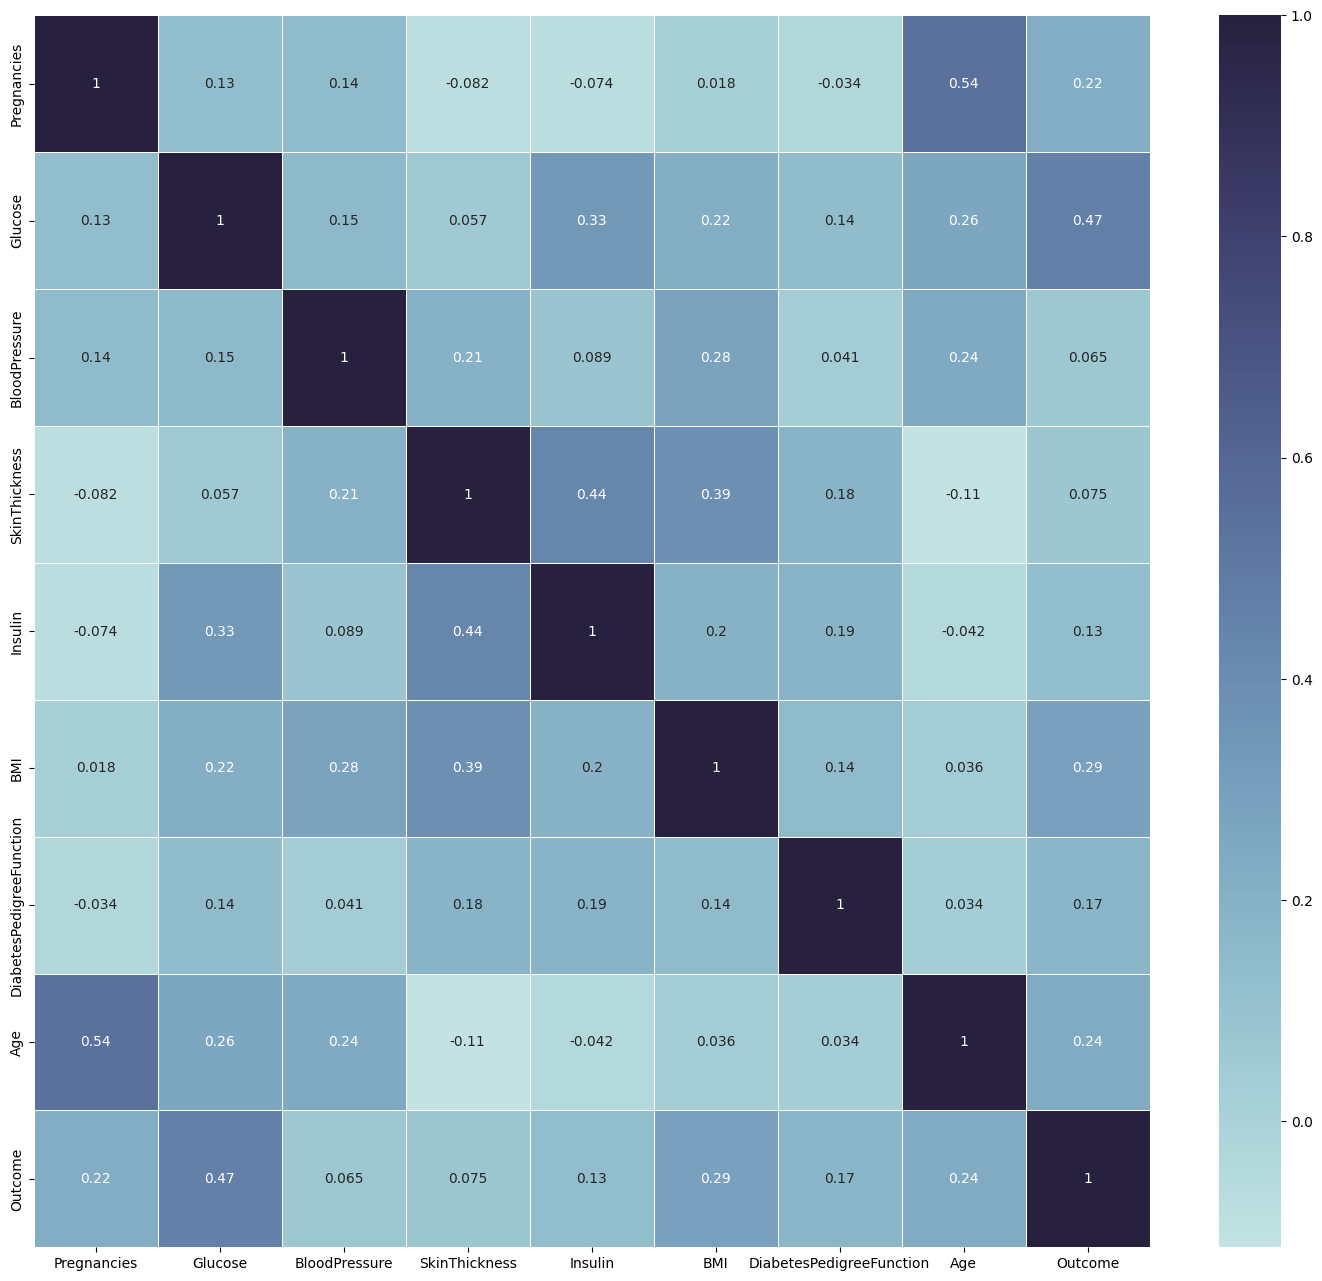

In [429]:
figure, ax = plt.subplots(figsize = (18,16))
axis = sns.heatmap(diabetes_df.corr(), annot= True, ax=ax, linewidths=0.6, cmap=plots_palette)
plt.show()

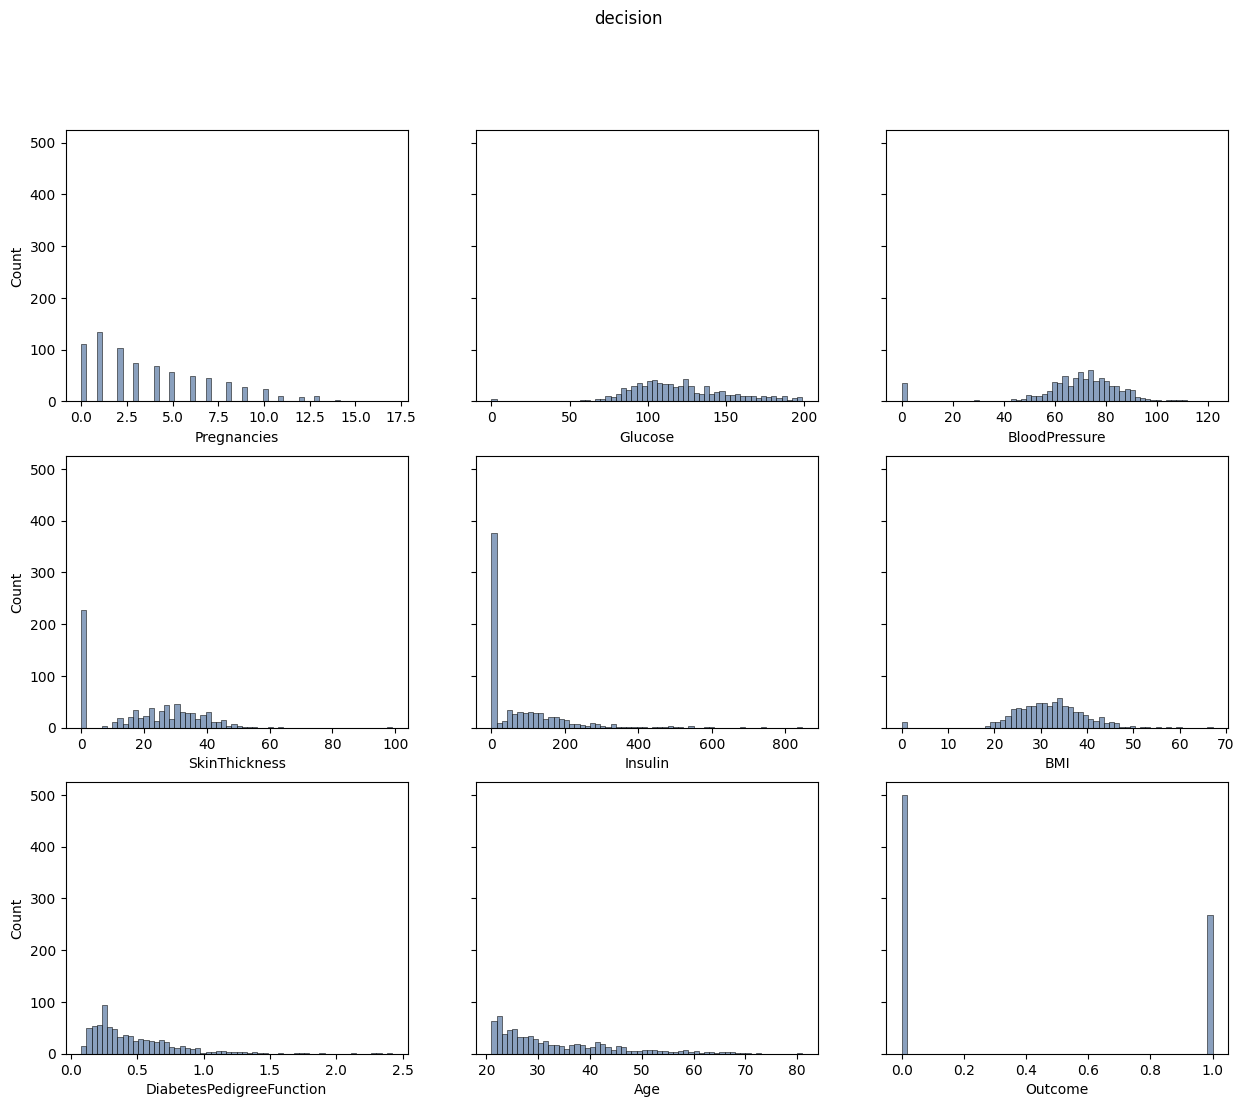

In [430]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey=True)
fig.suptitle('decision')

i = 0
for j in range(3):
    for k in range(3):
        sns.histplot(ax = axes[j,k], data = diabetes_df, x = numerical_features[i], color=plots_color, bins=60)
        i = i + 1


### create models

In [431]:
def split_dataframe(dataframe, test_size=0.25,val_size=0.5, random_state=1 ):

    '''
    =============================
    This function divides the dataframe into three parts (train, val, test).
    To correctly calculate the validation part, we subtract the desired percentage 
    from the total percentage (specifics of the sklearn library).
    =============================
    '''

    X = dataframe.iloc[:, :-1]
    y = dataframe.iloc[:, -1]
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=abs(val_size - 1), random_state=random_state, shuffle=True)

    print(f'train set size: {X_train.shape[0]}')
    print(f'test set size: {X_test.shape[0]}')
    print(f'validation set size: {X_val.shape[0]}')
    
    return X_train, X_test, y_train, y_test, X_val, y_val

In [432]:
handle_style_dict=dict(description_width='16',handle_color='#3e3565')

test_size_widget = widgets.IntSlider(value=30, min=10, max=50,step=1, 
                                     orientation='horizontal',
                                     style=handle_style_dict)
test_size_widget_box = HBox([Label('Test size(% of all data)'), test_size_widget])

validation_size_widget = widgets.IntSlider(value=60, min=10, max=80,step=1,
                                           orientation='horizontal',
                                           style=handle_style_dict)
validation_size_widget_box = HBox([Label('Validation size(% of test %)'), validation_size_widget])

In [437]:
display(test_size_widget_box, validation_size_widget_box)

In [439]:
X_train, X_test, y_train, y_test, X_val, y_val = split_dataframe(dataframe=diabetes_df,
                                                                 test_size=test_size_widget.value/100,
                                                                 val_size=validation_size_widget.value/100)

train set size: 537
test set size: 132
validation set size: 99


#### NN model

In [440]:
scaler = MinMaxScaler()

X_train_normal = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

In [441]:
bounded_text_style = dict(description_width='20')

int_layer_size_widget = widgets.BoundedIntText(value=32, min=8,max=32,step=2, style=bounded_text_style)
int_layer_size_widget_box = HBox([Label('Int layer size: '), int_layer_size_widget])

hide_layer_size_widget = widgets.BoundedIntText(value=256, min=16,max=1024,step=2, style=bounded_text_style)
hide_layer_size_widget_box = HBox([Label('Hiden layer size: '), hide_layer_size_widget])

dropout_widget = widgets.BoundedFloatText(value=0.5, min=0.1,max=0.99,step=0.1, style=bounded_text_style)
dropout_widget_box = HBox([Label('Dropout value: '), dropout_widget])

threshold_widget = widgets.BoundedFloatText(value=0.5, min=0.1,max=0.99,step=0.1, style=bounded_text_style)
threshold_widget_box = HBox([Label('Threshold value: '), threshold_widget])

In [442]:
display(int_layer_size_widget_box, 
        hide_layer_size_widget_box,
        dropout_widget_box,
        threshold_widget_box)

In [443]:
class NeuralNetwork(nn.Module):

    '''
    =============================
    This class initializes the neural network model. 
    The init function has several hidden layers, 
    the parameters of which are configured in the widget above
    =============================
    '''
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(8, int_layer_size_widget.value)
        init.trunc_normal_(tensor=self.fc1.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout1 = nn.Dropout(0.5)  
        self.fc2 = nn.Linear(int_layer_size_widget.value, hide_layer_size_widget.value)
        init.trunc_normal_(tensor=self.fc2.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hide_layer_size_widget.value, hide_layer_size_widget.value)
        init.trunc_normal_(tensor=self.fc3.weight,mean=0,std=0.1,a=-1,b=1)

        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(hide_layer_size_widget.value,1)
        init.trunc_normal_(tensor=self.fc4.weight,mean=0,std=0.1,a=-1,b=1)

        self.sigmoid = nn.Threshold(threshold=threshold_widget.value,value=0)
    
    def forward(self, x):
        x = F.tanh(self.fc1(x))

        x = self.dropout1(x)
        x = F.tanh(self.fc2(x))

        
        x = self.dropout2(x)
        x = F.tanh(self.fc3(x))

        x = self.dropout3(x)
        x = F.tanh(self.fc4(x))

        x = self.sigmoid(x)
        x = torch.round(x)
        return x

In [444]:
class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y

In [445]:
y_train = torch.tensor(y_train.values, dtype=torch.float)
X_train_normal = torch.tensor(X_train_normal.values,dtype=torch.float)

y_test = torch.tensor(y_test.values, dtype=torch.float)
X_test = torch.tensor(X_test.values,dtype=torch.float)

y_val = torch.tensor(y_val.values, dtype=torch.float)
X_val = torch.tensor(X_val.values,dtype=torch.float)

In [446]:
y_train = y_train.unsqueeze(1)
train_dataset = CustomDataset(X_train_normal, y_train)

y_test = y_test.unsqueeze(1)
test_dataset = CustomDataset(X_test, y_test)

y_val = y_test.unsqueeze(1)
X_val = CustomDataset(X_test, y_test)

In [447]:
batchsize_widget = widgets.BoundedIntText(value=64, min=16,max=256,step=2, style=bounded_text_style)
batchsize_widget_box = HBox([Label('Batchsize: '), batchsize_widget])

In [448]:
display(batchsize_widget_box)

In [572]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=batchsize_widget.value, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batchsize_widget.value, shuffle=True)
val_dataloader = DataLoader(dataset=test_dataset, batch_size=batchsize_widget.value, shuffle=True)


In [450]:
def test(model, test_loader):

    '''
    =============================
    this function evaluates 
    the performance of the neural network
    =============================
    '''
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    accuracy = 100 * correct / total 
    return accuracy

In [569]:
def train_model(model, train_loader, test_loader, val_loader, epochs, optimizer, print_plot):

    '''
    =============================
    This function trains the neural network. 
    This is a standard function from the PyTorch documentation, 
    but with some modifications for convenience 
    (plots and accuracy assessment).
    =============================
    '''

    model.train()
    criterion = nn.CrossEntropyLoss()
    
    accuracies = []
    test_accuracies = []

    last_accuracy = 0

    for epoch in range(epochs):
        correct = 0
        total = 0
        for batch_idx,(inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            total += labels.size(0)
            correct += (outputs == labels).float().sum()
        accuracy = 100 * correct / total
        last_accuracy = accuracy

        test_accuracy = test(model=model,test_loader=val_loader) 

        accuracies.append(accuracy)
        test_accuracies.append(test_accuracy)

        if test_accuracy > 75:
            break

    
    if print_plot is True:
        plt.plot(range(1, len(accuracies) + 1), accuracies, label='Train Accuracy')
        plt.plot(range(1, len(accuracies) + 1),  test_accuracies, label='Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy(%)')
        plt.title(f'{optimizer.__class__.__name__}')
        plt.legend()
        plt.show()

    test_accuracy = test(model=model,test_loader=test_loader) 
    return( last_accuracy.item(), test_accuracy)

In [453]:
columns_labels = ['model','lr', 'momentum','amsgrad','weight_decay','epochs', 'train_score','test_score']
score_df = pd.DataFrame(columns=columns_labels)

In [454]:
num_lr = [0.1**5, 0.1**4, 0.1 **3, 0.1**2]
num_momentum = [0.5, 0.75, 0.9]
is_amsgrad = [True, False]
num_weight_decay = [0.01, 0.1, 0.5, 0.9]
epochs = 400

In [456]:
i = 1
for lr in num_lr:
    for momentum in num_momentum:
        for amsgrad in is_amsgrad:
            for weight_decay in num_weight_decay:
                    
                nn_model = NeuralNetwork()
                adam_optim = optim.Adam(nn_model.parameters(),lr = lr,weight_decay = weight_decay, amsgrad = amsgrad)

                print(f'[{i}]  optimizer: {adam_optim.__class__.__name__} | lr:{lr} | momentum:{momentum} | amsgrad:{amsgrad} | decay:{weight_decay} | epochs:{epochs}')

                train_accuracy, test_accuracy = train_model(model = nn_model,
                                                            train_loader = train_dataloader,
                                                            test_loader = test_dataloader,
                                                            val_loader = val_dataloader,
                                                            epochs = epochs,
                                                            optimizer = adam_optim, 
                                                            print_plot = False)

                print(f'[!] train_accuracy: {round(train_accuracy,4)} | test_accuracy: {round(test_accuracy,4)}')
                print(' ')

                model_df = pd.DataFrame(data=[[adam_optim.__class__.__name__,lr,momentum,amsgrad,weight_decay,epochs,train_accuracy,test_accuracy]], columns = columns_labels)
                score_df = pd.concat([score_df,model_df], ignore_index=True)
                    
                i = i + 1
                test(nn_model,test_dataloader)

[1]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:True | decay:0.01 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 44.697
 
[2]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:True | decay:0.1 | epochs:400


C:\Users\Senya\AppData\Local\Temp\ipykernel_16996\221347933.py:24: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  score_df = pd.concat([score_df,model_df], ignore_index=True)


[!] train_accuracy: 65.9218 | test_accuracy: 61.3636
 
[3]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:True | decay:0.5 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 59.8485
 
[4]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:True | decay:0.9 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 59.8485
 
[5]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:False | decay:0.01 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 61.3636
 
[6]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:False | decay:0.1 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 59.8485
 
[7]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:False | decay:0.5 | epochs:400
[!] train_accuracy: 65.9218 | test_accuracy: 59.8485
 
[8]  optimizer: Adam | lr:1.0000000000000003e-05 | momentum:0.5 | amsgrad:False | decay:0.9 | epochs:400
[!] train_accuracy: 65.9218 | test_accura

In [457]:
sorted_score_df = score_df.sort_values(by = 'test_score', ascending = False)

sorted_score_df.head(5)

,model,lr,momentum,amsgrad,weight_decay,epochs,train_score,test_score
18,Adam,0.00001,0.90,True,0.50,400,65.921791,66.666667
1,Adam,0.00001,0.50,True,0.10,400,65.921791,61.363636
4,Adam,0.00001,0.50,False,0.01,400,65.921791,61.363636
61,Adam,0.00100,0.75,False,0.10,400,65.921791,59.848485
70,Adam,0.00100,0.90,False,0.50,400,65.921791,59.848485


In [458]:
best_parameters = sorted_score_df.iloc[0,:]

#### after conducting experiments with the model and optimizer, you can more accurately adjust the parameters for training

In [459]:
epochs_widget = widgets.BoundedIntText(value=300, min=1,max=2000,step=1, style=bounded_text_style)
epochs_widget_box = HBox([Label('Epochs value: '), epochs_widget])

lr_widget = widgets.BoundedFloatText(value= 0.01 , min = 0.1**5, max=0.99, style=bounded_text_style)
lr_widget_box = HBox([Label('Learning rate value: '), lr_widget])

weight_decay_widget = widgets.BoundedFloatText(value= 0.1 , min = 0.1**5, max=0.99, style=bounded_text_style)
weight_decay_widget_box = HBox([Label('L1 value: '), weight_decay_widget])


amsgrad_widget = widgets.Checkbox(value= True,  style=bounded_text_style)
amsgrad_widget_box = HBox([Label('Amsgrad value: '), amsgrad_widget])                     

In [460]:
display(epochs_widget_box,lr_widget_box,weight_decay_widget_box,amsgrad_widget_box)

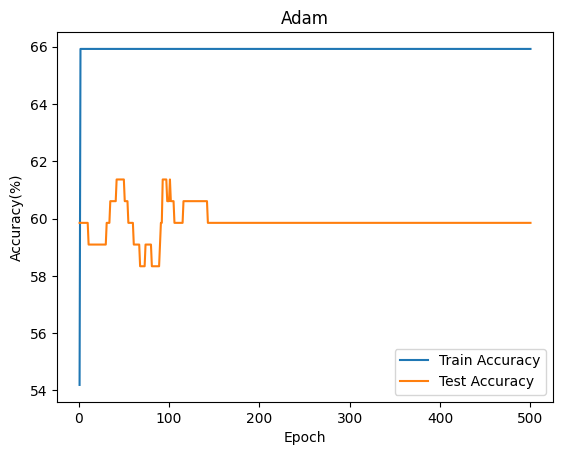

trainn accuracy: 65.92179107666016, test accuracy: 59.84848484848485


In [573]:
nn_model = NeuralNetwork()
adam_optim = optim.Adam(nn_model.parameters(), lr = lr_widget.value, 
                        weight_decay = weight_decay_widget.value, amsgrad = amsgrad_widget.value)

train_accuracy, test_accuracy = train_model(model = nn_model,
                                            train_loader = train_dataloader,
                                            test_loader = test_dataloader,
                                            val_loader = val_dataloader,
                                            epochs = epochs_widget.value,
                                            optimizer = adam_optim, 
                                            print_plot = True)

print(f'trainn accuracy: {train_accuracy}, test accuracy: {test_accuracy}')

### decision tree

In [477]:
def split_dataframe(dataframe, test_size=0.25, random_state=1 ):

    '''
    =============================
    This function divides the dataframe into three parts (train, val, test).
    To correctly calculate the validation part, we subtract the desired percentage 
    from the total percentage (specifics of the sklearn library).
    =============================
    '''

    X = dataframe.iloc[:, :-1]
    y = dataframe.iloc[:, -1]
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)

    print(f'train set size: {X_train.shape[0]}')
    print(f'test set size: {X_test.shape[0]}')
    
    return X_train, X_test, y_train, y_test

In [478]:
test_size_widget = widgets.IntSlider(value=30, min=10, max=50,step=1, 
                                     orientation='horizontal',
                                     style=handle_style_dict)
test_size_widget_box = HBox([Label('Test size(% of all data)'), test_size_widget])

In [479]:
display(test_size_widget_box)

In [485]:
X_train, X_test, y_train, y_test = split_dataframe(dataframe=diabetes_df,test_size=test_size_widget.value/100)

train set size: 576
test set size: 192


In [481]:
max_depth_widget = widgets.IntSlider(value=16, min=1, max=50,step=1, 
                                     orientation='horizontal',
                                     style=handle_style_dict)

max_depth_widget_box = HBox([Label('Max depth'), max_depth_widget])

max_features_widget = widgets.IntSlider(value=12, min=1, max=50,step=1, 
                                     orientation='horizontal',
                                     style=handle_style_dict)

max_features_widget_box = HBox([Label('Feature depth'), max_features_widget])

max_leaf_nodes_widget = widgets.IntSlider(value=16, min=2, max=50,step=1, 
                                     orientation='horizontal',
                                     style=handle_style_dict)

max_leaf_nodes_widget_box = HBox([Label('Max leaf nodes'), max_leaf_nodes_widget])

In [482]:
display(max_depth_widget_box,
        max_features_widget_box,
        max_leaf_nodes_widget_box)

In [568]:
tree_classifier_model = tree.DecisionTreeClassifier(max_depth = max_depth_widget.value,
                                max_features = max_features_widget.value, 
                                max_leaf_nodes= max_leaf_nodes_widget.value)
tree_classifier_model = tree_classifier_model.fit(X_train, y_train)

y_pred = tree_classifier_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {100 * accuracy:.4} %")

Accuracy: 80.21 %


### Research result: the neural network model showed a maximum accuracy of 59.2-65 %. 
### The decision tree model showed an accuracy of 80.2 %.

#### save model

In [576]:
model_file_name = 'diabetes-classifier-model.pkl'

joblib.dump(tree_classifier_model, model_file_name)

['diabetes-classifier-model.pkl']